In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark

In [2]:
resolution = 100  #grid resolution in meters
outPath = f"{os.curdir}{os.sep}output{os.sep}"
outputFileName = f"{outPath}AggLidarData_UpperDelta_{resolution}m.pickle"
#captureHoods = ['GENTILLY TERRACE','GENTILLY WOODS','MARIGNY','BYWATER','ST. CLAUDE','PONTCHARTRAIN PARK','DESIRE AREA',\
#               'FRENCH QUARTER','ST. BERNARD AREA', 'ST. CLAUDE', 'ST. ROCH']
captureHoods = []

In [3]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [4]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-28 19:39:32.817740] Starting...


In [5]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName(outputFileName).setMaster("spark://127.0.0.1:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-28 19:39:32.823003] Creating spark context


25/03/28 20:39:33 WARN Utils: Your hostname, G-ChaosStation resolves to a loopback address: 127.0.1.1; using 192.168.12.163 instead (on interface eno1)
25/03/28 20:39:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/28 20:39:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-28 19:39:35.576681] Path:  ./datasets/		FullPath:/home/g/Dev/NewOrleansElevation/datasets/


In [7]:
testLasFileName = os.listdir(f"{dataPath}lazUpperDelta")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}lazUpperDelta{os.sep}{testLasFileName}")

[2025-03-28 19:39:35.583542] Opening USGS_LPC_LA_UpperDeltaPlain_2015_15rzp115375.laz to get crs and more


In [8]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

In [9]:
sorted(neighborhoodDf['gnocdc_lab'].unique())

['ALGIERS POINT',
 'AUDUBON',
 'B. W. COOPER',
 'BAYOU ST. JOHN',
 'BEHRMAN',
 'BLACK PEARL',
 'BROADMOOR',
 'BYWATER',
 'CENTRAL BUSINESS DISTRICT',
 'CENTRAL CITY',
 'CITY PARK',
 'DESIRE AREA',
 'DILLARD',
 'DIXON',
 'EAST CARROLLTON',
 'EAST RIVERSIDE',
 'FAIRGROUNDS',
 'FILMORE',
 'FISCHER DEV',
 'FLORIDA AREA',
 'FLORIDA DEV',
 'FRENCH QUARTER',
 'FRERET',
 'GARDEN DISTRICT',
 'GENTILLY TERRACE',
 'GENTILLY WOODS',
 'GERT TOWN',
 'HOLLYGROVE',
 'HOLY CROSS',
 'IBERVILLE',
 'IRISH CHANNEL',
 'LAKE CATHERINE',
 'LAKE TERRACE & OAKS',
 'LAKESHORE - LAKE VISTA',
 'LAKEVIEW',
 'LAKEWOOD',
 'LEONIDAS',
 'LITTLE WOODS',
 'LOWER GARDEN DISTRICT',
 'LOWER NINTH WARD',
 'MARIGNY',
 'MARLYVILLE - FONTAINEBLEAU',
 'MID-CITY',
 'MILAN',
 'MILNEBURG',
 'McDONOGH',
 'NAVARRE',
 'NEW AURORA - ENGLISH TURN',
 'OLD AURORA',
 'PINES VILLAGE',
 'PLUM ORCHARD',
 'PONTCHARTRAIN PARK',
 'READ BLVD EAST',
 'READ BLVD WEST',
 'SEVENTH WARD',
 'ST.  ANTHONY',
 'ST. BERNARD AREA',
 'ST. CLAUDE',
 'ST. ROCH

In [10]:
if len(captureHoods) > 0:
    captureHoodsMask = neighborhoodDf['gnocdc_lab'].isin(captureHoods)
else:
    captureHoodsMask = np.repeat(True, neighborhoodDf.shape[0])

<Axes: >

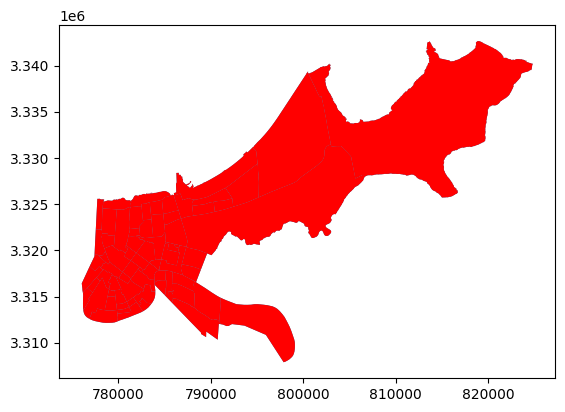

In [11]:
ax = neighborhoodDf.plot()
neighborhoodDf[captureHoodsMask].plot(ax=ax, color='red')

In [12]:
bounds = [int(b) for b in neighborhoodDf[captureHoodsMask].total_bounds]

In [13]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-28 19:39:36.927570] Resolution will be 48.807 x 34.758  Runtime based on 1696.4337060000003


In [14]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf[captureHoodsMask].union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()


<Axes: >

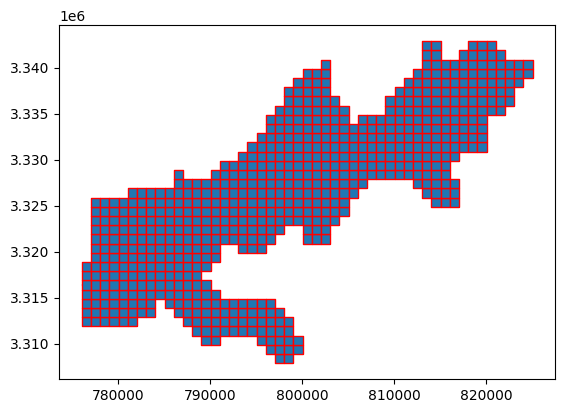

In [15]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [16]:
tileIndex = gpd.read_file(f"{dataPath}UpperDeltaPlainLATileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['TILENAME'].map(lambda f: f"{fullDataPath}lazUpperDelta{os.sep}USGS_LPC_LA_UpperDeltaPlain_2015_{f.lower()}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex)
tileIndexBroadcast.value.head()

,TILENAME,geometry
TILENAME,,
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp545750.laz,15RYP545750,"POLYGON ((754500 3375000, 754500 3376500, 7560..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp560750.laz,15RYP560750,"POLYGON ((756000 3375000, 756000 3376500, 7575..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp575750.laz,15RYP575750,"POLYGON ((757500 3375000, 757500 3376500, 7590..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp590750.laz,15RYP590750,"POLYGON ((759000 3375000, 759000 3376500, 7605..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp605750.laz,15RYP605750,"POLYGON ((760500 3375000, 760500 3376500, 7620..."


In [17]:
tileIndex

,TILENAME,geometry
TILENAME,,
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp545750.laz,15RYP545750,"POLYGON ((754500 3375000, 754500 3376500, 7560..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp560750.laz,15RYP560750,"POLYGON ((756000 3375000, 756000 3376500, 7575..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp575750.laz,15RYP575750,"POLYGON ((757500 3375000, 757500 3376500, 7590..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp590750.laz,15RYP590750,"POLYGON ((759000 3375000, 759000 3376500, 7605..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp605750.laz,15RYP605750,"POLYGON ((760500 3375000, 760500 3376500, 7620..."
...,...,...
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryn590655.laz,15RYN590655,"POLYGON ((759000 3265500, 759000 3267000, 7605..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryn560640.laz,15RYN560640,"POLYGON ((756000 3264000, 756000 3265500, 7575..."
/home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryn575640.laz,15RYN575640,"POLYGON ((757500 3264000, 757500 3265500, 7590..."


In [18]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')


def processLas(inputTup):
    startTime = datetime.now()
    
    BoxIdx = inputTup[0]
    boxBounds = inputTup[1:]
    
    lp(f"Processing for box[{BoxIdx}] {boxBounds}")

    altTotal = 0
    waterTotal = 0
    pointTotal = 0
    for idx, row in tileIndexBroadcast.value.iterrows():
        if not row['geometry'].intersects(shapely.box(*boxBounds)):
            #no intersection scip
            continue

        try:        
            las = laspy.read(idx)
        except FileNotFoundError:
            lp(f"path {idx} does not exist skipping" )
            continue
        
        
        central_meridian = int(meridianReg.findall(las.header.vlrs[0].string)[0]) * -1
    
        
        X = las.X
        Y = las.Y
        Z = las.Z
        cls = las.classification
    
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (boxBounds[0]*1000), (X <= (boxBounds[2]*1000)))
        inBoundsMaskY = np.logical_and(Y >= (boxBounds[1]*1000), (Y <= (boxBounds[3]*1000)))
        goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
        
        x = X[goodPointMask]/1000.0 #- bounds[0]
        y = (Y[goodPointMask]/1000.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        pointTotal += np.count_nonzero(goodPointMask)

    return (BoxIdx,altTotal, waterTotal, pointTotal, datetime.now() - startTime)


In [19]:
#Just for sanity
testIdx = 7
processLas(list(boxesDf.bounds.itertuples())[testIdx])

[2025-03-28 19:39:37.911994] Processing for box[39] (777039.0, 3311888.0, 778039.0, 3312888.0)
[2025-03-28 19:39:38.901512] path /home/g/Dev/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp770105.laz does not exist skipping


(39, 0, 0, 0, datetime.timedelta(seconds=1, microseconds=61043))

In [20]:
boxesRdd = sc.parallelize(boxesDf.bounds.itertuples(), 300)

In [21]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [22]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-28 19:39:39.209839] 648 boxes total


In [23]:
output = boxesProcessedRdd.collect()

In [24]:
boxesDf.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'Total', 'RunTime'], dtype='object')

In [25]:
output[0]

(4, 0, 0, 0, datetime.timedelta(seconds=5, microseconds=967665))

In [26]:
for out in output:
    boxesDf.loc[out[0], 'AltitudeTotal'] = out[1]
    boxesDf.loc[out[0], 'WaterTotal'] = out[2]
    boxesDf.loc[out[0], 'Total'] = out[3]
    boxesDf.loc[out[0], 'RunTime'] = out[4]

In [27]:
lp(f"{boxesDf['RunTime'].mean()} avg runtime\t\ttotal:  {boxesDf['RunTime'].sum()}")

[2025-03-28 19:56:01.962371] 0 days 00:00:05.899256 avg runtime		total:  0 days 01:03:42.717929


In [28]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,Total,RunTime
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",0.0,0.0,0.0,0 days 00:00:05.967665
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",0.0,0.0,0.0,0 days 00:00:12.429327
6,"POLYGON ((777039 3313888, 777039 3314888, 7760...",0.0,0.0,0.0,0 days 00:00:08.163574
7,"POLYGON ((777039 3314888, 777039 3315888, 7760...",0.0,0.0,0.0,0 days 00:00:14.558961
8,"POLYGON ((777039 3315888, 777039 3316888, 7760...",0.0,0.0,0.0,0 days 00:00:15.735437


In [29]:
boxesDf.to_pickle(outputFileName)

In [30]:
with open(f"{outPath}FinishTime_UpperDelta_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

<Axes: >

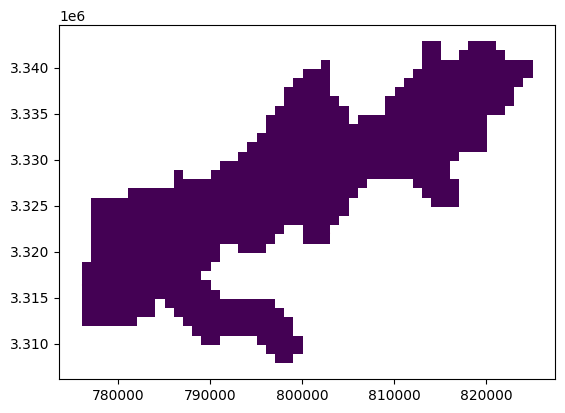

In [31]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='AltCalc',ax=ax)

In [32]:
lp("Done!")

[2025-03-28 19:56:02.263179] Done!


In [33]:
#the actual runs where don using ProcessLidar.py because of problems with connection issues and its effects on long running notebooks